# <center>尝鲜Github Action</center>

By [青衣极客 Blue geek](https://mp.weixin.qq.com/s/9klEeE88nAhC4Vbvhvc4XQ)

In 2020-03-30

在软件的产品线中，常常有一个环节——持续集成(CI)。CI的作用是执行一些编译、测试、发布和部署这一类通用工作流程的，在工作划分清晰的团队中，通常是由QA来负责维护的。如果某次提交的代码无法正常通过CI，则QA有权禁止该代码合并到主干分支。由于CI的流程清晰，功能必要，以及多项目通用，因此有一些软件专门来做CI的自动化。对于个人或者小团队而言，维护一个CI自动化系统是繁琐而不必要的，因为Github所推出的Action功能能够帮助我们方便地执行CI，而且是免费的。

## 1. Github提供的资源

github在被微软收购之后，除了推出免费的私有仓库之外，还有提供了一个土豪的功能——Action。Action需要一台能够执行代码的计算机，Github就为每次执行Action功能提供一台虚拟机。

### (1) 硬件资源

该虚拟机所具有的硬件资源如下：

```
A. 2核心的CPU
B. 7GB内存
C. 14GB的SSD
```

对于我们这样的小门小户而言，这样的资源完全够用。

### (2) 操作系统

有多个操作系统开发经验的朋友基本会有一个共识，即最好开发用的系统与部署使用的系统一致或者至少类型一致。比如，在Windows下开发，然后在Linux系统中部署的话，就会产生很多的麻烦，稍不留神就会造成故障。Github提供了目前最常用的3种操作系统。

|虚拟环境|	YAML 工作流程标签|
|:---:|:---:|
|Windows Server 2019|	windows-latest 或 windows-2019|
|Ubuntu 18.04|	ubuntu-latest 或 ubuntu-18.04|
|Ubuntu 16.04|	ubuntu-16.04|
|macOS Catalina 10.15|	macos-latest or macos-10.15|

YAML工作流程标签是可以在yaml配置文件中使用的符号，这里只需要知道Github Action可以提供Windows、Ubuntu和macOS三种操作系统的虚拟机。如果你的开发环境正在使用的操作系统是其中一种的话，可以选择对应的虚拟机操作系统。

### (3) 使用限制

在使用Github Action时面临一些限制，虽然个人或者小团队用户基本不会超越，但我们仍然需要知道这一点。

A. 在workflow中的每个Job都不应超过6个小时，否则会因无法完成而失败。

B. 每个workflow执行实现不能超过72个小时。

C. 自托管Job最多只能排队24个小时。

D. 当前仓库的所有actions执行Github API的频率不能超过1000次/每小时。

E. 并行任务数量的上限见下表

|GitHub 计划|同时运行的作业总数|MacOS 作业同时运行的最大数量|
|:---:|:---:|:---:|
|免费|20|5|
|Pro|40|5|
|团队|60|5|
|企业|180|50|

F. 每个workflow的job数量不能超过256个。

## 2. Github Action的worflow语法简介

github的action功能有仓库根目录下的`.github/workflows`目录下的`.yml`后缀文件定义。每一个yaml文件定义一个workflow，一个workflow可以包含若干个job，每一个job可以包含若干个step，这些step会串行执行，每个step包含若干个action。

### (1) name

`name`字段设置当前workflow的名字，默认情况下为文件名。

### (2) on

`on` 字段用于指明当前workflow启动的时机，我们通常是需要在修改代码库时启动workflow，可以选择push或者pull_request。
例如：

```yaml
on: [push, pull_request]
```

我们也可以设置地详细一点，比如master分支发生push事件时启动的配置如下：

```yaml
on:
  push:
    branches:
      - master
```

### (3) jobs

`jobs` 字段用于定义一个任务，如果这些任务存在依赖关系，可以使用`need`字段加以说明，例如：

```yaml
jobs:
  a_job:
  b_job:
    need: a_job
  c_job:
    nedd: [a_job, b_job]
```

### (4) run-on

`run-on` 字段用于指定虚拟机的类型，比如：

```yaml
jobs:
  build:
    runs-on: macos-latest
```

就是指在“build”任务中使用“macOS”操作系统的虚拟机。

### (5) steps

`steps` 字段用于定义一系列步骤，每一个步骤以“- name”开始定义该步骤的名字，随后可选择使用“uses”字段引用第三方action或者docker，使用“env”字段设置环境变量，使用“run”字段设置需要运行的指令。其中“uses”和“run”是二选一的必填字段。


### (6) action

在“steps”中使用“uses”字段引用的就是action，该action可以自定义，也可以直接引用第三方的。通常我们都是引用github上已经写好的action。比如拉取当前的代码库的master分支的配置如下：

```yaml
jobs:
  build:
    runs-on: macos-latest
    steps:
    - name: Checkout
          uses: actions/checkout@master
```

关于workflow配置的基本语法就讨论到这里，更加详细的说明和教程，可以参考github官网给出的文档。

## 3. 一个macOS编译C++程序的例子

这里展示一个在macOS虚拟机中编译C++程序的例子。

### (1) C++源码

首先编写一个`src/main.cpp`文件：

```C++
#include <gflags/gflags.h>
#include <gtest/gtest.h>
#include <glog/logging.h>

using namespace std;

TEST(Hello, World) {
    cout << "HelloWorld" << endl;
}

int main(int argc, char ** argv) {
    google::ParseCommandLineFlags(&argc, &argv, true);
    google::InitGoogleLogging(argv[0]);
    google::SetStderrLogging(google::GLOG_INFO);
    
    int ret = 0;
    // run testcases
    testing::InitGoogleTest();
    ret = RUN_ALL_TESTS();
    google::ShutdownGoogleLogging();
    return ret;
}
```

在“src/main.cpp”文件中依赖了gflags、glog以及gtest三个库。

### (2) 编写cmake文件

为了便于组织依赖关系，这里使用cmake来编译工程，`CMakeLists.txt`文件内容如下：

```cmake
cmake_minimum_required(VERSION 2.8.12)
project(github_action)

# depend gflags
find_package(gflags REQUIRED)
message(STATUS "depend gflags include: ${gflags_INCLUDE_DIR}")
message(STATUS "depend gflags lib: ${gflags_LIB}")
include_directories(${gflags_INCLUDE_DIR})
set(gflags_LIB gflags)
set(LIBS ${LIBS} ${gflags_LIB})

#depend gtest
find_package(GTest REQUIRED)
message(STATUS "depend gtest include: ${GTEST_INCLUDE_DIR}")
message(STATUS "depend gtest lib: ${GTEST_BOTH_LIBRARIES}")
include_directories(${GTEST_INCLUDE_DIR})
set(LIBS ${LIBS} ${GTEST_BOTH_LIBRARIES})

#depend glog
find_package(Glog REQUIRED)
message(STATUS "depend glog include: ${GLOG_INCLUDE_DIRS}")
message(STATUS "depend glog lib: ${GLOG_LIBRARIES}")
set(GLOG_INCLUDE_DIRS ${GTEST_INCLUDE_DIR})
set(GLOG_LIBRARIES glog::glog)
include_directories(${GLOG_INCLUDE_DIRS}) 
set(LIBS ${LIBS} ${GLOG_LIBRARIES})

# depend protobuf
find_package(Protobuf REQUIRED)
if(PROTOBUF_FOUND)
    message(STATUS "protobuf library found")
else()
    message(FATAL_ERROR "protobuf library is needed but cant be found")
endif() 
include_directories(${PROTOBUF_INCLUDE_DIRS})
include_directories(${CMAKE_CURRENT_BINARY_DIR})
set(LIBS ${LIBS} ${PROTOBUF_LIBRARIES})

# display depending libs
message(STATUS "depend libs: ${LIBS}")

# set include and compiler params
include_directories(include/)
add_definitions(-std=c++11)
add_definitions(-g)
add_definitions(-Wall)
set(CMAKE_C_COMPILER gcc)
#set(CMAKE_CXX_COMPILER g++)
message(STATUS "CMAKE_CXX_COMPILER=${CMAKE_CXX_COMPILER}")

# create executable files
aux_source_directory(./src DIR_SRC)

add_executable(${PROJECT_NAME} ${DIR_SRC} ${PROTO_SRCS} ${PROTO_HDRS})
target_link_libraries(${PROJECT_NAME} ${LIBS} ${EXT_LIBS})
```

### (3) workflow配置

以上的源码和编译依赖都组织完毕，接下来就可以配置workflow了。编写“.github/workflows/main.yml”文件：

```yaml
name: TestGithubActions
on: push
jobs:
  build:
    runs-on: macos-latest
    steps:
    - name: Installation depends
      run: |
        ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
        brew install protobuf
        brew install gflags
        brew install glog
        brew install tree
        git clone http://github.com/google/googletest
        cd googletest
        echo `cmake --version`
        mkdir build && cd build
        echo "running cmake ..."
        cmake .. -DCMAKE_CXX_STANDARD=11
        echo "running make ..."
        make
        echo "running install ..."
        make install
    - name: Checkout
      uses: actions/checkout@master

    - name: Check Source Code Dir
      run: |
        pwd
        tree .
    - name: Build
      run: |
        mkdir build && mkdir logdir && cd build
        cmake .. >> ../logdir/cmake.log
        make -j2 >> ../logdir/make.log
    - name: Run TestCases and Generate Report
      run: |
        ./build/github_action >> ./logdir/testcase_report.txt
        
    - name : Upload artifact
      uses: actions/upload-artifact@master
      with:
        name: TestcaseReport
        path: ./logdir
```

这段配置指定了如下的流程：(1) 当前workflow的名称为TestGithubActions，(2) 在push事件发生时触发，(3) 执行build任务，(4) build任务需要在“macOS”中执行，(5) 首先在虚拟机系统中安装依赖，(6) 拉取仓库源码，(7) 检查源码目录结构，(8) 编译并执行生成日志文件，(9) 将日志文件上传到本次workflow的主页。

将以上文件组成的仓库push到github上，即可在“Actions”标签下查看workflow的运行情况。

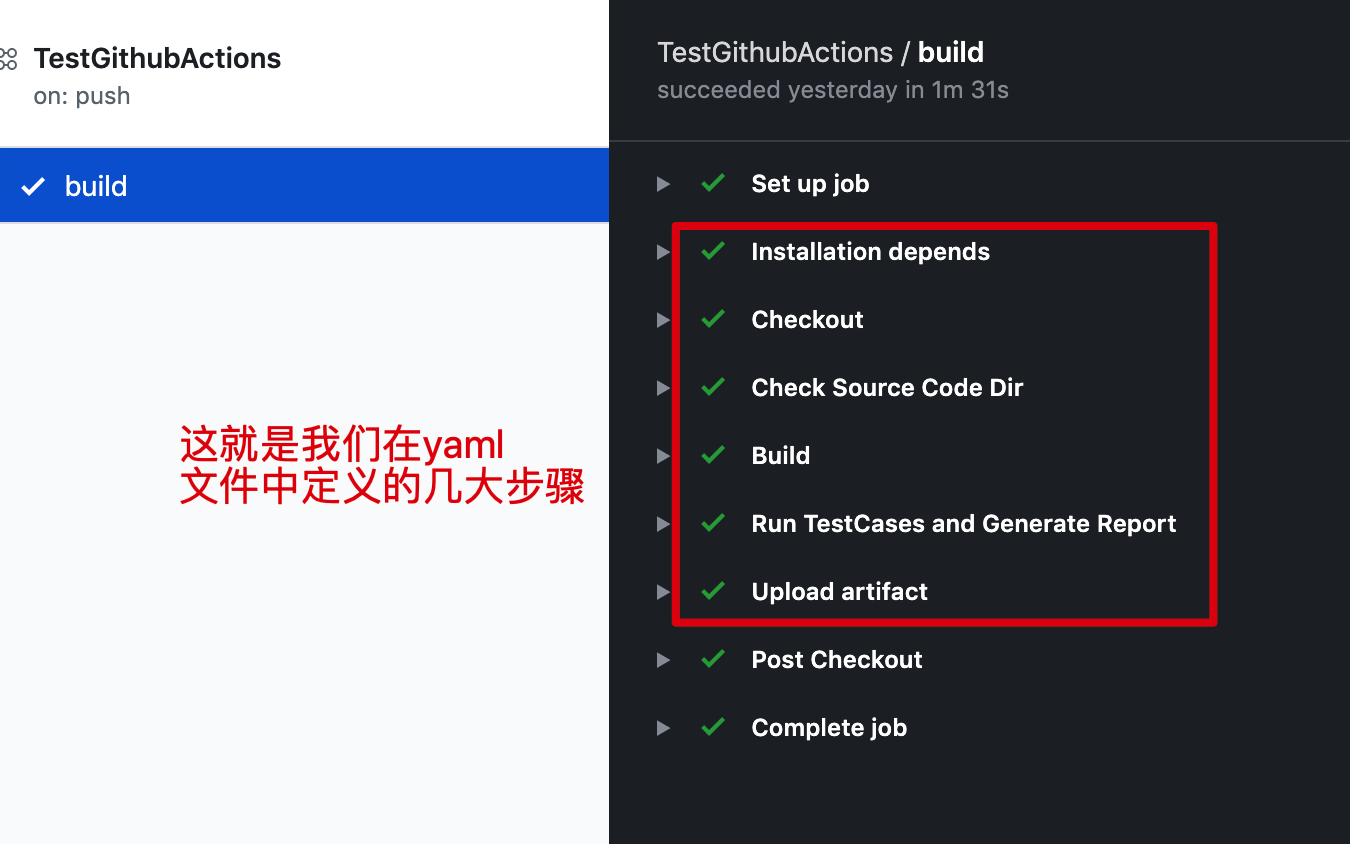

In [2]:
from IPython.display import Image
Image("./images/bg76/steps.png")

等到流程走完，就可以看到产出。

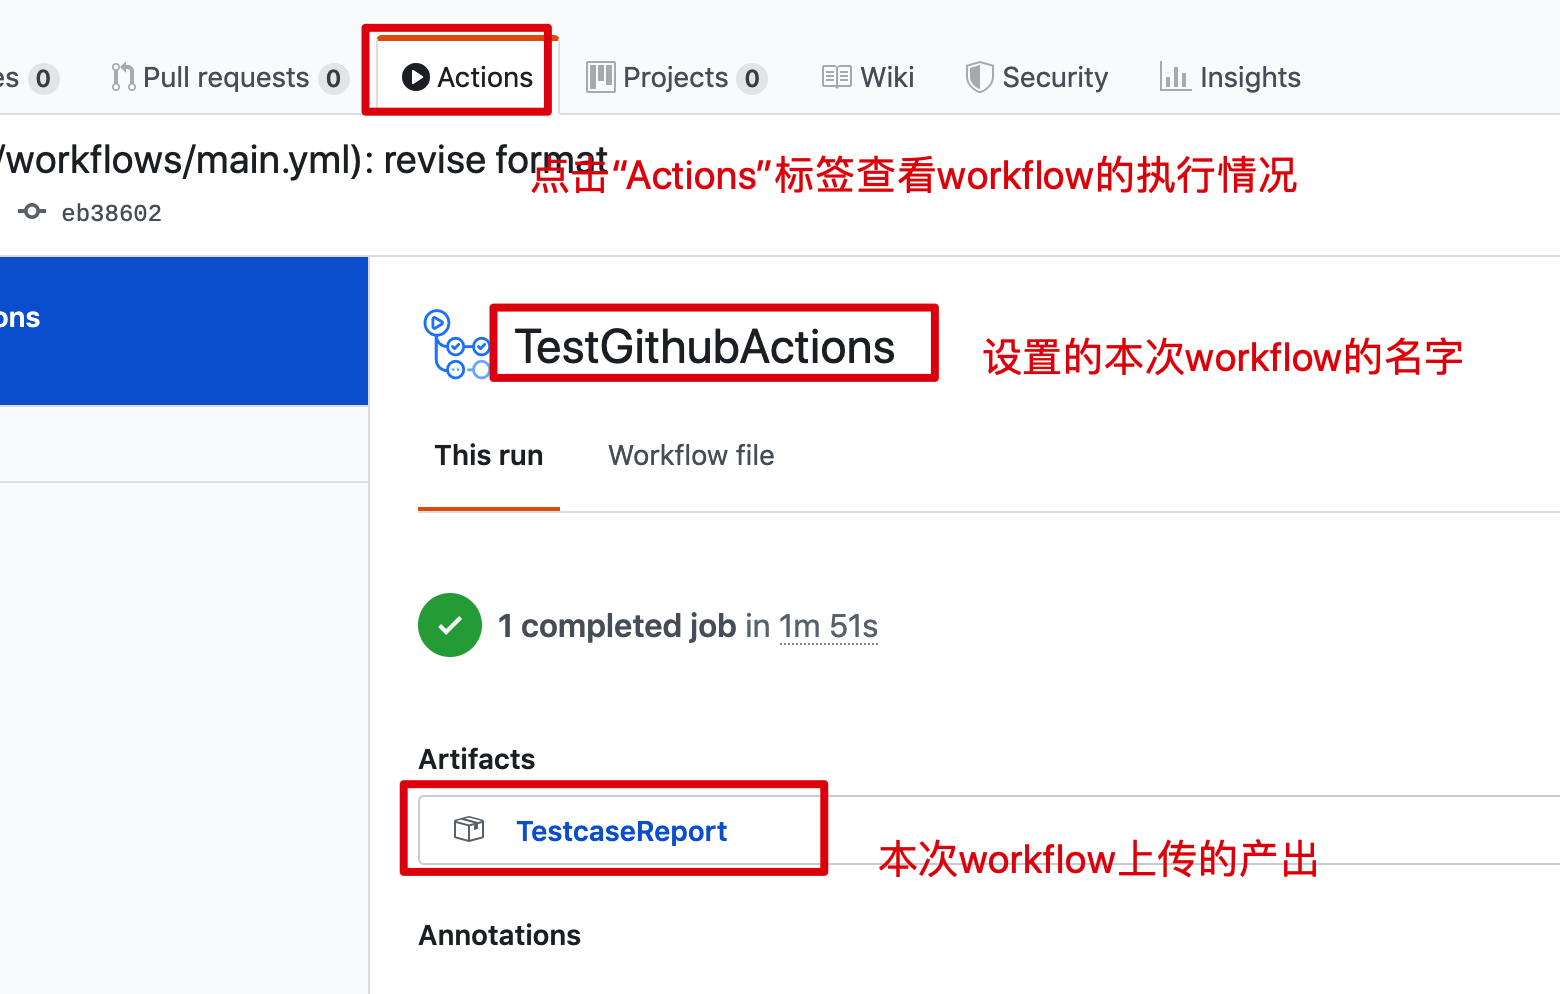

In [3]:
Image("./images/bg76/results.png")

通常第一次尝试都没有那么顺利，大多会由于各种问题导致执行失败。可以根据页面中展示的失败步骤日志分析失败原因，然后修正再push。每次执行失败都会自动发送邮件到用户邮箱中。实验成功之后，就可以在自己的项目中使用Github Action功能了，配置好workflow之后就可以让开发人员专注于代码逻辑，而不必分心维护CI流程。